In [10]:
#plot ERPs based on eventprobs/resampling 
#     - New VERSION (only on P, with BRPs) What about 8th panel? Can always use this for legends)
############################################

#resample
import scipy
import seaborn as sns
import matplotlib.font_manager as font_manager
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from scipy.stats import sem
import numpy as np
import hmp 
import xarray as xr

In [2]:
epoch_data =  hmp.utils.load_data('data/hmp_data/epoch_data.nc')

In [3]:
epoch_data = epoch_data.rename({'event_name': 'cond'})

In [3]:
hmp_data = hmp.utils.transform_data(epoch_data, n_comp=4)

In [26]:
# parameters for the HMP model
event_width=50
location_corr_threshold=0.7
location_corr_duration=500

In [27]:
# init model
hmp_model = hmp.models.hmp(hmp_data, epoch_data, event_width=event_width, location_corr_threshold=location_corr_threshold, location_corr_duration=location_corr_duration)

In [28]:
backward = hmp_model.backward_estimation(max_events = 6)

Estimating all solutions for maximal number of events (6) with 1 pre-defined starting point and 0 random starting points
Estimating all solutions for 5 events
Estimating all solutions for 4 events
Estimating all solutions for 3 events
Estimating all solutions for 2 events
Estimating all solutions for 1 events


In [29]:
model = backward.sel(n_events = 3)

In [153]:
mags_map = np.array([[1, 1, 1],
                     [1, 1, 1],
                     [1, 1, 1],
                     [1, 1, 1]])


pars_map = np.array([[1, 1, 1, 1],
                     [1, 1, 1, 1],
                     [1, 1, 1, 1],
                     [1, 1, 1, 1]])

conds = {'event_name': ['A', 'B', 'C', 'D']}

mags = model.magnitudes.dropna('event').data
pars = model.parameters.dropna('stage').data

In [154]:
#fit the model 
model_conditions = hmp_model.fit_single_conds(magnitudes=mags, parameters=pars, pars_map=pars_map, mags_map=mags_map, conds=conds)

Condition "event_name" analyzed, with levels: ['A', 'B', 'C', 'D']

Coded as follows: 
0: ['A']
1: ['B']
2: ['C']
3: ['D']

Magnitudes map:
0:  [1 1 1]
1:  [1 1 1]
2:  [1 1 1]
3:  [1 1 1]

Parameters map:
0:  [1 1 1 1]
1:  [1 1 1 1]
2:  [1 1 1 1]
3:  [1 1 1 1]

Estimating 3 events model
parameters estimated for 3 events model


In [155]:
# creating resp-locked data, commented out for now
data_resp = epoch_data.to_array().squeeze()[:,:,:,:120] #max 1 sec
data_resp.values = np.zeros(data_resp.shape) * np.nan

#set every trial
for pp in data_resp.participant:
    for tr in data_resp.epochs:
       tmp = epoch_data.sel(participant=pp, epochs=tr).data.values
#        tmp = tmp[:,~np.isnan(tmp[0,:])]
#        if tmp.shape[1] < 500: # add nans at the start
#            tmp = np.concatenate((np.tile(np.nan,(tmp.shape[0],500-tmp.shape[1])),tmp),axis=1)
       
#        #find nan idx, go there back 500
#        data_resp[np.where(data_resp.participant==pp)[0][0],tr, :, :] = tmp[:,-500:]

In [156]:
#for each trial and each stage, resample data to average duration
times = hmp_model.compute_times(hmp_model, model_conditions, add_rt=True, fill_value=0, center_measure='median',estimate_method='max').unstack()
times_mean = hmp_model.compute_times(hmp_model, model_conditions, duration=False, mean=True, add_rt=True, fill_value=0, extra_dim='condition', center_measure='median',estimate_method='max').values
times_mean = np.round(times_mean)

In [157]:
#resampled
data_resampled = epoch_data.to_array().squeeze()
data_resampled.values = np.zeros(data_resampled.shape) * np.nan

#go to middle of event
shift = hmp_model.event_width_samples//2
times[1:4,:,:] = times[1:4,:,:] + shift #do not shift onset and RT
times_mean[:, 1:4] = times_mean[:, 1:4] + shift

for pp in times.participant:
    data_pp = epoch_data.sel(participant=pp).data.values
    times_pp = np.round(times.sel(participant=pp).values)
    for tr in np.arange(117):
        for st in np.arange(times_mean.shape[1]-1)+1:
            if not np.isnan(data_pp[tr,:,:]).all():

                dat = data_pp[tr, :, int(times_pp[st-1,tr]):int(times_pp[st,tr])]
                datt = dat.shape[1]

                #if stage > 0 we resample, in the few other cases it will have nans
                if datt > 0:                

                    #pad extra
                    dat = np.concatenate([np.tile(dat[:,0],(datt,1)).T, dat, np.tile(dat[:,-1],(datt,1)).T],axis=1)

                    c = epoch_data.sel(participant=pp).data[tr,0,0].event_name.values
                    cidx = np.where(model_conditions.conds_dict[0]['event_name'] == c)[0][0]
                    newdur = int(times_mean[cidx,st] - times_mean[cidx,st-1])
                    
                    #resample
                    datnew = scipy.signal.resample_poly(dat, newdur,datt, axis=1, padtype='median')

                    #unpad
                    datnew = datnew[:,(newdur+1):(2*newdur)+1] 

                    data_resampled[np.where(data_resampled.participant==pp)[0][0],tr,:,int(times_mean[cidx,st-1]):int(times_mean[cidx,st])] = datnew

In [177]:
c

3

In [158]:
#HMPRPs, not resampled
time_hmprps = 60 #on either side

hmprps = []
for ev in range(3):
    hmprps.append(epoch_data.to_array().squeeze()[:,:,:,:int(time_hmprps)]) #600 ms (-300-300)
    hmprps[-1].values = np.zeros(hmprps[-1].shape) * np.nan

for pp in times.participant:
    data_pp = epoch_data.sel(participant=pp).data.values
    times_pp = np.round(times.sel(participant=pp).values)
    for tr in np.arange(117):
        for ev in range(3):
            if not np.isnan(data_pp[tr,:,:]).all(): #trial x channel x samples

                time_ev = int(times_pp[ev+1,tr])
                dat = data_pp[tr, :, np.max([0,int(time_ev-time_hmprps/2)]):int(time_ev+time_hmprps/2)]
                
                if dat.shape[1] < time_hmprps: #add nans where necessary
                    if time_ev < time_hmprps/2: #add at start
                        dat = np.concatenate((np.tile(np.nan,(tmp.shape[0],int(time_hmprps/2-time_ev))),dat),axis=1)
                    if time_ev > data_pp.shape[2] - time_hmprps/2:
                        dat = np.concatenate((dat,np.tile(np.nan,(tmp.shape[0],int(time_hmprps/2) - (data_pp.shape[2] - time_ev))),),axis=1)

                hmprps[ev][np.where(hmprps[ev].participant==pp)[0][0],tr, :, :] = dat




In [229]:
#general plot settings

xlims = (0,1200)
ylimsERP = [(-4,8), (-4,8), (-15,18)]

chans = ['Fz']
names = ['Stimulus-locked ERP ' + str(chans[0]), 'Respond-locked ERP ' + str(chans[0]), 'Discovered events', 'Event distributions', 'ERP - Event 1','ERP - Event 2','ERP - Event 3', 'ERP - Trial Resampled']
erp_names = names[0:2] + [names[-1]]
hmprp_names = names[4:7]
time_step = 1000/hmp_model.sfreq

condition_names_idx = ['A', 'B', 'C', 'D']
condition_names = ['A', 'B', 'C', 'D']
condition_names_rev = condition_names.copy()
condition_names_rev.reverse()

source_font = {'fontname':'sans-serif'}

channel_data = epoch_data.to_array().squeeze() #standard data

# plot_data = [channel_data, data_resp, data_resampled]
plot_data = [channel_data, channel_data, data_resampled]


In [118]:
channel_data.to_netcdf('data/visu_data/channel_data.nc')
data_resampled.to_netcdf('data/visu_data/data_resampled.nc')

In [46]:
#create fig and axes
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import os
from mne.io import read_info

In [49]:
epoch_data_path = os.path.join('data/subjects/')#Declaring path where the eeg data is
subj_names = [x.split('.')[0] for x in os.listdir(epoch_data_path) if 'epo.fif' in x]#Extracting subject name based on the file name
subj_files = [epoch_data_path+x+'.fif' for x in subj_names]#Create a list of files that can be read from the folder

info = read_info(subj_files[0], verbose=False)

In [288]:
fig = plt.figure(figsize=(40/2.54,60/2.54)) 
grid = plt.GridSpec(5, 4, wspace=0.7, hspace=.45, figure=fig)

ax_ERPs = [] #stim_locked, resp_locked, resampled
ax_ERPs.append(plt.subplot(grid[0,:2]))
ax_ERPs.append(plt.subplot(grid[0,2:]))
ax_ERPs.append(plt.subplot(grid[4,1:3]))

ax_discovered = plt.subplot(grid[1,:2])
ax_distris = plt.subplot(grid[1,2:])

gs1 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec = grid[2,:], wspace = .05)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec = grid[3,:], wspace = .05)

ax_HMPRPs1 = [plt.subplot(gs1[0,0])]
for i in range(2):
    ax_HMPRPs1.append(plt.subplot(gs1[0,1+i], sharey=ax_HMPRPs1[0], ylim=ylimsERP[0]))
    plt.setp(ax_HMPRPs1[-1].get_yticklabels(), visible=False)
ax_HMPRPs2 = [plt.subplot(gs2[0,0])]
for i in range(2):
    ax_HMPRPs2.append(plt.subplot(gs2[0,1+i], sharey=ax_HMPRPs2[0], ylim=ylimsERP[2]))
    plt.setp(ax_HMPRPs2[-1].get_yticklabels(), visible=False)

if True:
    #plot discovered events

    ax_cur = ax_discovered
    hmp.visu.plot_topo_timecourse(epoch_data, model_conditions, info, hmp_model, magnify=1.2, sensors=False, as_time=True,contours=0, title="Neutral condition model",center_measure='median',estimate_method='max',ax=ax_cur, vmin=ylimsERP[-1][0],vmax=ylimsERP[-1][1])

    ax_cur.set_title(names[2],fontsize=10, fontweight='semibold', **source_font)
    ax_cur.set_ylabel('',fontsize=18)
    ax_cur.set_xlabel('Time (ms)',fontsize=9, **source_font, fontweight='light')
    ax_cur.tick_params(axis='x', labelsize=8)
    ax_cur.tick_params(axis='y', labelsize=9)
    ax_cur.set_yticklabels(labels=condition_names_rev,**source_font, fontweight='light')
    #ax[fig_idx].set_ylim((0,5))
    ax_cur.set_xlim(xlims)
    for label in ax_cur.get_xticklabels():
        # label.set_fontname('Source Sans Pro') 
        label.set_fontweight('light')

    #adjust
    for child in ax_cur.get_children():
        if type(child) == matplotlib.collections.LineCollection:
            child.set(linewidth=.5)
            
            #change color response line
            if np.allclose(child.get_ec()[0], np.array([0.12156863, 0.46666667, 0.70588235, 1.])):
                child.set_ec('darkgrey')

        #topo (or colorbar?)
        if type(child) == matplotlib.axes._axes.Axes:
            
            if child.get_ylabel() == 'Voltage': #colorbar

                child.tick_params(axis='y', labelsize=8)
                for label in child.get_yticklabels():
                    # label.set_fontname('Source Sans Pro') 
                    label.set_fontweight('light')
                child.yaxis.offsetText.set_fontsize(8)
                # child.yaxis.offsetText.set_fontname('Source Sans Pro') 
                child.yaxis.offsetText.set_fontweight('light')
                child.set_ylabel('',fontsize=9, **source_font, fontweight='light')
                ip = InsetPosition(ax_cur,[.86,.6,.02,.3])
                child.set_axes_locator(ip)
            else: #topo
                for child2 in child.get_children():
                    if type(child2) == matplotlib.lines.Line2D:
                        child2.set(linewidth=.5) 

    #plot distributions of events
                        
    ax_cur = ax_distris

    densities = []

    spaces = np.array([1, .66, .33, .0])
    heights = np.diff(spaces) * -1

    for ev in range(3):
        
        #events
        #subax_evs = ax[fig_idx].inset_axes([0,.75-.25*ev,1,.25],sharex=ax[fig_idx])
        subax_evs = ax_cur.inset_axes([0,spaces[ev+1],1,heights[ev]],sharex=ax_cur)

        for c in range(4):
            times_ev4 = times.sel(event=ev+1)
            times_ev4_c = times_ev4.stack(trial_x_participant=('participant','trials')).dropna('trial_x_participant')
            times_ev4_c = times_ev4_c[times_ev4_c.cond==c]

            #plot events
            subax_evs.vlines(times_ev4_c.values*time_step-time_step/2,.725-.15*c, .625-.15*c,linestyle = '-',color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][c],alpha=.08, linewidth=.5)

            #add median
            subax_evs.vlines(times_mean[c,ev+1]*time_step-time_step/2,.745-.15*c, .615-.15*c,linestyle = '-',color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][c],alpha=1,linewidth=1.0)

        subax_evs.set_ylim((0,1))
        subax_evs.axis('off')

        #densities

        #subax_dens = ax[fig_idx].inset_axes([0,.75-.25*ev,1,.25],sharex=ax[fig_idx])
        subax_dens = ax_cur.inset_axes([0,spaces[ev+1],1,heights[ev]],sharex=ax_cur)

        for c in range(3):
            times_ev4 = times.sel(event=ev+1)
            times_ev4_c = times_ev4.stack(trial_x_participant=('participant','trials')).dropna('trial_x_participant')
            times_ev4_c = times_ev4_c[times_ev4_c.cond==c]
            #plot densities
            #calc density
            densities.append(scipy.stats.gaussian_kde(times_ev4_c.values*time_step-time_step/2).evaluate(np.arange(0,xlims[1])))
            subax_dens.plot(densities[-1],color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][c],linewidth=1.0,label=condition_names[c])

        #subax.set_xlim(xlims)
        subax_dens.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False,
            left=False,
            right=False,
            labelleft=False) # labels along the bottom edge are off
        subax_dens.set_ylabel('')
        #subax_dens.set_ylim((0, np.max(densities)*.8))
        subax_dens.set_ylim((0, np.array(np.max(densities)*1.05*heights/heights[0])[ev])) #heights/heights[0]
        subax_dens.axis('off')

    for yval in spaces[1:4]: #[.25,.5,.75]:
        ax_cur.axhline(y = yval, color='grey',linewidth=.5)

    ax_cur.set_title(names[3],fontsize=10, fontweight='semibold', **source_font)
    ax_cur.set_xlabel('Time (ms)',fontsize=9, **source_font, fontweight='light')
    ax_cur.tick_params(axis='x', labelsize=8)
    ax_cur.tick_params(axis='y', labelsize=9)
    #ax[fig_idx].set_yticks(np.array([0, .25, .5, .75])+.125, labels=['Event 4','Event 3','Event 2','Event 1'])
    ax_cur.set_yticks(spaces[0:3]-heights/2, labels=['Event 1','Event 2','Event 3'],**source_font, fontweight='light')
    for label in ax_cur.get_xticklabels():
        # label.set_fontname('Source Sans Pro') 
        label.set_fontweight('light')
    ax_cur.set_xlim(xlims)

    #switch off 1e-5 on ev 2-4, move it on ev1
    #make x-axes all 500 wide or so
    #remove space in between
    
#plot ERPs: stim locked, resp locked, resampled

for erp in range(3):

    ax_cur =  ax_ERPs[erp]

    # get channels and average across channels
    chans_sel = plot_data[erp][:,:,np.isin(channel_data.channels, chans),:]
    chans_sel = chans_sel.mean('channels')

    #and across condition
    means = []
    ses = []
    for cond in condition_names_idx:
        chans_cond = chans_sel.where(chans_sel.event_name==cond, drop=True)
        means.append(chans_cond.groupby('participant').mean('epochs').mean('participant'))
        ses.append(chans_cond.groupby('participant').mean('epochs').reduce(sem, dim='participant',nan_policy='omit'))
    means = np.array(means)
    ses = np.array(ses)

    #0 line
    ax_cur.axhline(y = 0, linestyle = '--',color='lightgrey',linewidth=.5)

    #if resampled plot lines of each event and resp
    if erp == 2:
        for c in range(4):
            ax_cur.vlines(times_mean[c,1:4]*time_step-time_step/2,ylimsERP[erp][0], ylimsERP[erp][1],linestyle = '--',color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][c],alpha=.5,linewidth=.5)
            ax_cur.vlines(times_mean[c,4]*time_step-time_step/2,ylimsERP[erp][0], ylimsERP[erp][1],linestyle = '--',color='darkgrey',alpha=.5,linewidth=.5)
    
    #errors
    for c in range(4):
        ax_cur.fill_between(np.arange(time_step/2, xlims[1], time_step), means[c,:int(np.round(xlims[1]/time_step))] - ses[c,:int(np.round(xlims[1]/time_step))], means[c,:int(np.round(xlims[1]/time_step))] + ses[c,:int(np.round(xlims[1]/time_step))],
                color=['C0','C1', 'C2','C3'][c], alpha=0.2, linewidth=.1)
    
    #means
    ax_cur.plot(np.arange(time_step/2, xlims[1], time_step), means[:,:int(np.round(xlims[1]/time_step))].T,label=condition_names,linewidth=1)
    ax_cur.set_title(erp_names[erp],fontsize=10, fontweight='semibold', **source_font)
    ax_cur.set_ylabel('Voltage',fontsize=9, **source_font, fontweight='light')
    ax_cur.set_xlabel('Time (ms)',fontsize=9, **source_font, fontweight='light')
    ax_cur.tick_params(axis='x', labelsize=8)
    ax_cur.tick_params(axis='y', labelsize=8)
    #ax[fig_idx].set_xticklabels(ax[fig_idx].get_xticklabels(),**source_font, fontweight='light')
    for label in ax_cur.get_xticklabels():
        # label.set_fontname('Source Sans Pro') 
        label.set_fontweight('light')
    for label in ax_cur.get_yticklabels():
        # label.set_fontname('Source Sans Pro') 
        label.set_fontweight('light')
    ax_cur.yaxis.offsetText.set_fontsize(8)
    # ax_cur.yaxis.offsetText.set_fontname('Source Sans Pro') 
    ax_cur.yaxis.offsetText.set_fontweight('light')

    ax_cur.set_ylim(ylimsERP[erp])
    ax_cur.set_xlim(xlims)
    if erp > 0:
        leg = ax_cur.legend(prop=font_manager.FontProperties(weight='light', size=8),framealpha=.6, borderpad=.2, labelspacing = .3, handlelength=.6, handletextpad=.4,borderaxespad=0.2)
        leg.get_frame().set_linewidth(0.0)
 

#plot HMPRPs
for ev in range(6):

    if ev < 3:
        ax_cur =  ax_HMPRPs1[ev]
    else:
        ev = ev - 3
        ax_cur =  ax_HMPRPs2[ev]

    # get channels and average across channels
    chans_sel = hmprps[ev][:,:,np.isin(channel_data.channels, chans),:]
    chans_sel = chans_sel.mean('channels')

    #and across condition
    means = []
    ses = []
    for cond in condition_names_idx:
        chans_cond = chans_sel.where(chans_sel.event_name==cond, drop=True)
        means.append(chans_cond.groupby('participant').mean('epochs').mean('participant'))
        ses.append(chans_cond.groupby('participant').mean('epochs').reduce(sem, dim='participant',nan_policy='omit'))
    means = np.array(means)
    ses = np.array(ses)

    #0 line 
    ax_cur.axhline(y = 0, linestyle = '--',color='lightgrey',linewidth=.5)
    if ev == 0:
        ax_cur.axvline(x = 0, linestyle = '--',color='lightgrey',linewidth=.5)

    #plot lines of each event and resp
    for c in range(4):
        ax_cur.vlines(times_mean[c,ev+1]*time_step-time_step/2,ylimsERP[2][0], ylimsERP[2][1],linestyle = '--',color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][c],alpha=.5,linewidth=.5)
        if ev == 3: #add RT
            ax_cur.vlines(times_mean[c,4]*time_step-time_step/2,ylimsERP[erp][0], ylimsERP[erp][1],linestyle = '--',color='darkgrey',alpha=.5,linewidth=.5)
    
    #errors
    # for c in range(4):
    #     ax_cur.fill_between(np.arange(time_step/2, time_hmprps*2, time_step)-time_hmprps+times_mean[c,ev+1]*time_step-time_step/2, means[c,:] - ses[c,:], means[c,:] + ses[c,:], color=['C0','C1', 'C2','C3'][c], alpha=0.2, linewidth=.1)
    
    #means
    for c in range(4):
        ax_cur.plot(np.arange(time_step/2, time_hmprps*10, time_step)-time_hmprps+times_mean[c,ev+1]*time_step-time_step/2, means[c,:],label=condition_names[c],linewidth=1)
    ax_cur.set_title(hmprp_names[ev],fontsize=10, fontweight='semibold', **source_font)
    if ev == 0:
        ax_cur.set_ylabel('Voltage',fontsize=9, **source_font, fontweight='light')
    ax_cur.set_xlabel('Time (ms)',fontsize=9, **source_font, fontweight='light')
    ax_cur.tick_params(axis='x', labelsize=8)
    ax_cur.tick_params(axis='y', labelsize=8)
    #ax[fig_idx].set_xticklabels(ax[fig_idx].get_xticklabels(),**source_font, fontweight='light')
    for label in ax_cur.get_xticklabels():
        # label.set_fontname('Source Sans Pro') 
        label.set_fontweight('light')
    for label in ax_cur.get_yticklabels():
        # label.set_fontname('Source Sans Pro') 
        label.set_fontweight('light')
    ax_cur.yaxis.offsetText.set_fontsize(8)
    # ax_cur.yaxis.offsetText.set_fontname('Source Sans Pro') 
    ax_cur.yaxis.offsetText.set_fontweight('light')
    ax_cur.yaxis.offsetText.set_text('')

    #ax_HMPRPs1[-1].get_yaxis().get_major_formatter().set_useOffset(False)


    #ax_cur.set_ylim(ylimsERP[erp])
    xmid = np.median(times_mean[:,ev+1])*time_step
    ax_cur.set_xlim((xmid-time_hmprps-50,xmid+time_hmprps+50))
    



#fig.tight_layout()
plt.savefig('HMP-ERPs.pdf',dpi=300,transparent=True,bbox_inches='tight',backend='cairo')

After this is just test code

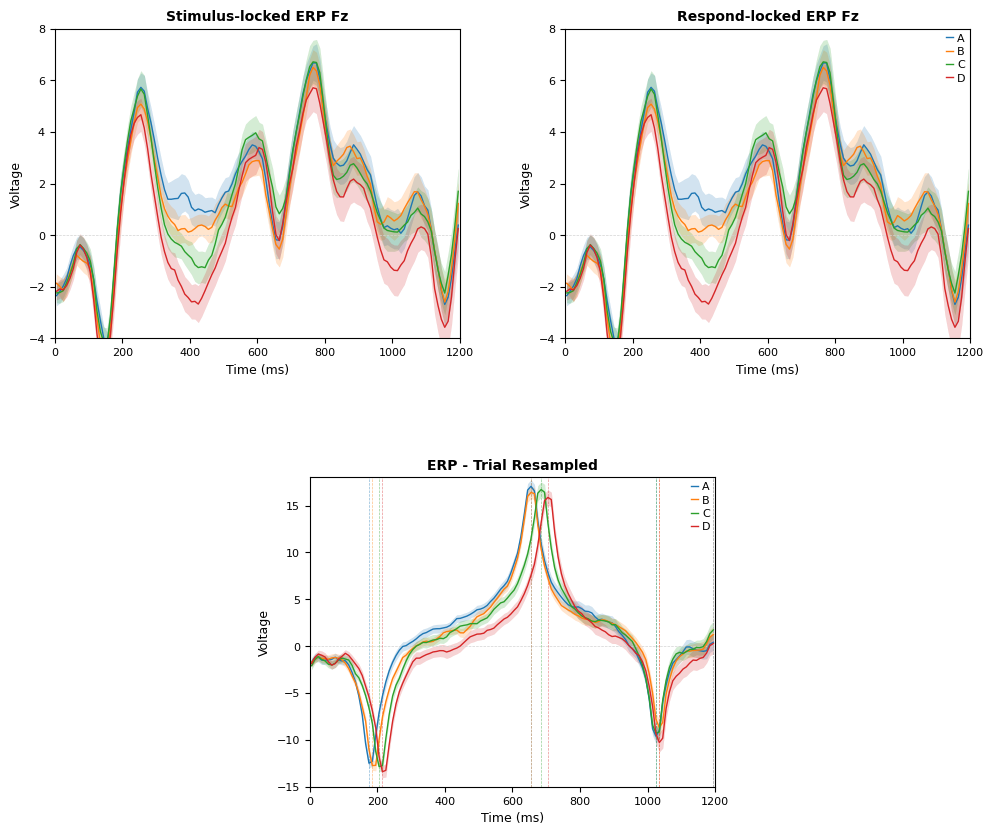

In [178]:
fig = plt.figure(figsize=(30/2.54,25/2.54)) 
grid = plt.GridSpec(2, 4, wspace=0.7, hspace=.45, figure=fig)

ax_ERPs = [] #stim_locked, resp_locked, resampled
ax_ERPs.append(plt.subplot(grid[0,:2]))
ax_ERPs.append(plt.subplot(grid[0,2:]))
ax_ERPs.append(plt.subplot(grid[1,1:3]))


#plot ERPs: stim locked, resp locked, resampled

for erp in range(3):

    ax_cur =  ax_ERPs[erp]

    # get channels and average across channels
    chans_sel = plot_data[erp][:,:,np.isin(channel_data.channels, chans),:]
    chans_sel = chans_sel.mean('channels')

    #and across condition
    means = []
    ses = []
    for cond in condition_names_idx:
        chans_cond = chans_sel.where(chans_sel.event_name==cond, drop=True)
        means.append(chans_cond.groupby('participant').mean('epochs').mean('participant'))
        ses.append(chans_cond.groupby('participant').mean('epochs').reduce(sem, dim='participant',nan_policy='omit'))
    means = np.array(means)
    ses = np.array(ses)

    #0 line
    ax_cur.axhline(y = 0, linestyle = '--',color='lightgrey',linewidth=.5)

    #if resampled plot lines of each event and resp
    if erp == 2:
        for c in range(4):
            ax_cur.vlines(times_mean[c,1:4]*time_step-time_step/2,ylimsERP[erp][0], ylimsERP[erp][1],linestyle = '--',color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][c],alpha=.5,linewidth=.5)
            ax_cur.vlines(times_mean[c,4]*time_step-time_step/2,ylimsERP[erp][0], ylimsERP[erp][1],linestyle = '--',color='darkgrey',alpha=.5,linewidth=.5)
    
    #errors
    for c in range(4):
        ax_cur.fill_between(np.arange(time_step/2, xlims[1], time_step), means[c,:int(np.round(xlims[1]/time_step))] - ses[c,:int(np.round(xlims[1]/time_step))], means[c,:int(np.round(xlims[1]/time_step))] + ses[c,:int(np.round(xlims[1]/time_step))],
                color=['C0','C1', 'C2','C3'][c], alpha=0.2, linewidth=.1)
    
    #means
    ax_cur.plot(np.arange(time_step/2, xlims[1], time_step), means[:,:int(np.round(xlims[1]/time_step))].T,label=condition_names,linewidth=1)
    ax_cur.set_title(erp_names[erp],fontsize=10, fontweight='semibold', **source_font)
    ax_cur.set_ylabel('Voltage',fontsize=9, **source_font, fontweight='light')
    ax_cur.set_xlabel('Time (ms)',fontsize=9, **source_font, fontweight='light')
    ax_cur.tick_params(axis='x', labelsize=8)
    ax_cur.tick_params(axis='y', labelsize=8)
    #ax[fig_idx].set_xticklabels(ax[fig_idx].get_xticklabels(),**source_font, fontweight='light')
    for label in ax_cur.get_xticklabels():
        # label.set_fontname('Source Sans Pro') 
        label.set_fontweight('light')
    for label in ax_cur.get_yticklabels():
        # label.set_fontname('Source Sans Pro') 
        label.set_fontweight('light')
    ax_cur.yaxis.offsetText.set_fontsize(8)
    # ax_cur.yaxis.offsetText.set_fontname('Source Sans Pro') 
    ax_cur.yaxis.offsetText.set_fontweight('light')

    ax_cur.set_ylim(ylimsERP[erp])
    ax_cur.set_xlim(xlims)
    if erp > 0:
        leg = ax_cur.legend(prop=font_manager.FontProperties(weight='light', size=8),framealpha=.6, borderpad=.2, labelspacing = .3, handlelength=.6, handletextpad=.4,borderaxespad=0.2)
        leg.get_frame().set_linewidth(0.0)


In [284]:
np.arange(time_step/2, time_hmprps*10, time_step)

array([  5.,  15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95., 105.,
       115., 125., 135., 145., 155., 165., 175., 185., 195., 205., 215.,
       225., 235., 245., 255., 265., 275., 285., 295., 305., 315., 325.,
       335., 345., 355., 365., 375., 385., 395., 405., 415., 425., 435.,
       445., 455., 465., 475., 485., 495., 505., 515., 525., 535., 545.,
       555., 565., 575., 585., 595.])

In [280]:
np.arange(time_step/2, time_hmprps*2, time_step)-time_hmprps+times_mean[c,ev+1]*time_step-time_step/2, means[c,:]

(array([ 980.,  990., 1000., 1010., 1020., 1030., 1040., 1050., 1060.,
        1070., 1080., 1090.]),
 array([ 3.35839814e+00,  3.48079893e+00,  3.59441002e+00,  3.64977321e+00,
         3.59029745e+00,  3.63193140e+00,  3.75247500e+00,  3.74095750e+00,
         3.56938334e+00,  3.31505720e+00,  3.32081760e+00,  3.29401170e+00,
         3.01487120e+00,  3.13149105e+00,  3.21557396e+00,  3.04169614e+00,
         2.65665477e+00,  2.25981041e+00,  1.94835793e+00,  1.53327614e+00,
         1.23379288e+00,  1.22621176e+00,  1.29940562e+00,  1.20802837e+00,
         9.92280722e-01,  3.84913940e-01, -9.40165721e-01, -3.16180203e+00,
        -6.53224684e+00, -1.01738964e+01, -1.19468119e+01, -1.08261273e+01,
        -7.43348067e+00, -4.12881535e+00, -2.37161029e+00, -1.11651533e+00,
        -3.85215104e-01,  2.70375441e-01,  3.97361225e-01, -4.38987088e-03,
         3.25459961e-02,  8.25185951e-02,  7.00877755e-01,  1.43653146e+00,
         1.79400030e+00,  2.21999210e+00,  2.56540959e+00,  2.

In [190]:
times_mean[c,ev+1]*time_step-time_step/2,ylimsERP[2][0]

(1035.0, -15)